In [76]:
import os
import sys
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging
from torch.utils.data import DataLoader
import multiprocessing
import tqdm
import ast
from annoy import AnnoyIndex
import cv2
import torchvision.transforms as transforms
from collections import Counter

from torchvision import transforms


In [2]:
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))

In [3]:
sys.path.append(os.path.join(dir_path, "src"))

In [4]:
from data_module import ImageDataModule
from resnet import Resnet50
from utils import collate_batch
from dataset import ImageDataset

/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ckpt = os.path.join(dir_path, "notebooks","lightning_logs","version_39","checkpoints","epoch=7-step=1952.ckpt")

In [6]:
model = Resnet50.load_from_checkpoint(ckpt, embedding_size=512, num_classes=19)

/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def load_image_arrary(file):
        path = os.path.join(dir_path, "images", "raw")
        image = cv2.imread(f"{path}/{file}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
        )
        transformations = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
        ]) 
        image = transformations(image)
        return image.unsqueeze(0) # add a batch channel

In [8]:
def extract_embedding(model, image):
    model.eval()
    with torch.no_grad():
        embedding = model(image)
    return embedding[0]


In [9]:
embedding_size = 512
annoy_index_file = 'annoy_index.ann'

In [10]:
loaded_annoy_index = AnnoyIndex(embedding_size, 'euclidean')
loaded_annoy_index.load(annoy_index_file)

True

In [20]:
index_df = pd.read_csv("metadata.csv", index_col=0)

In [11]:
upcoming_df = pd.read_csv(os.path.join(dir_path, "data", "upcoming.csv"), index_col=0)

In [12]:
upcoming_df

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,genres,genres_single
0,False,/fI5RsaM0NSU6TqztRhA2pal5ezv.jpg,"[28, 80, 53]",385687,en,Fast X,Over many missions and against impossible odds...,868.981,1E5baAaEse26fej7uHcjOgEE2t2.jpg,2023-05-17,Fast X,False,5.9,12,"['Action', 'Crime', 'Thriller']",['Action']
1,False,/69HgAYpbJ04w6lUUVainsYxLabb.jpg,"[14, 28, 12]",455476,en,Knights of the Zodiac,"When a headstrong street orphan, Seiya, in sea...",334.127,1nbFEdIFprRNSWcCM0RUjQqZifF.jpg,2023-04-27,Knights of the Zodiac,False,6.5,34,"['Fantasy', 'Action', 'Adventure']",['Fantasy']
2,False,/hJoMSAltRx5xvlAXvKyDdugjucJ.jpg,"[12, 10751, 14, 10749]",447277,en,The Little Mermaid,"The youngest of King Triton’s daughters, and t...",309.798,ym1dxyOk4jFcSl4Q2zmRrA5BEEN.jpg,2023-05-18,The Little Mermaid,False,5.7,6,"['Adventure', 'Family', 'Fantasy', 'Romance']",['Adventure']
3,False,/vnPTLSBk95XKdahOaMkTlAck5Rc.jpg,"[28, 18, 10752]",882569,en,Guy Ritchie's The Covenant,"After an ambush, Afghan interpreter Ahmed goes...",252.812,aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg,2023-04-19,Guy Ritchie's The Covenant,False,7.8,67,"['Action', 'Drama', 'War']",['Action']
4,False,/9xfDWXAUbFXQK585JvByT5pEAhe.jpg,"[16, 28, 12, 878]",569094,en,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Miles Morales...",119.826,zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg,2023-05-31,Spider-Man: Across the Spider-Verse,False,0.0,0,"['Animation', 'Action', 'Adventure', 'Science ...",['Animation']
5,False,/igXrblWrU1uaC09VKyquHHSebr.jpg,"[28, 53]",717930,en,Kandahar,"After his mission is exposed, an undercover CI...",69.786,gVh7d9n9WtUS6VSEaRXpGSTyhHW.jpg,2023-05-25,Kandahar,False,0.0,0,"['Action', 'Thriller']",['Action']
6,False,/tbQ7bEg5qnk7zR1bsi4xMqnaIRu.jpg,"[80, 9648, 53]",536437,en,Hypnotic,A detective becomes entangled in a mystery inv...,54.847,mv362kHXz4Yr33wtQhqfcJWFM8G.jpg,2023-05-11,Hypnotic,False,6.0,1,"['Crime', 'Mystery', 'Thriller']",['Crime']
7,False,/rfhrG37ikF5pOm9pJTbgfIlGK5g.jpg,"[10749, 18, 35]",758336,en,Love Again,"Mira Ray, dealing with the loss of her fiancé,...",54.415,usfDx1g1eN9eZ8kxfrbLRkKVjit.jpg,2023-05-04,Love Again,False,7.0,4,"['Romance', 'Drama', 'Comedy']",['Romance']
8,False,/gGZxCy9keK0D6TxbmS8GJj85Ut4.jpg,"[80, 35]",809787,en,Mafia Mamma,A suburban American woman inherits her grandfa...,52.446,zi0Lrmtvhrz52VXUjwEKlXItF9q.jpg,2023-04-13,Mafia Mamma,False,7.2,36,"['Crime', 'Comedy']",['Crime']
9,False,/pS4oSxn9g0PAzkWD5zrSOuRIgT6.jpg,"[35, 12, 14]",798286,en,Beau Is Afraid,A paranoid man embarks on an epic odyssey to g...,50.792,wgVkkjigF31r1nZV80uV0xNIoun.jpg,2023-04-14,Beau Is Afraid,False,7.3,196,"['Comedy', 'Adventure', 'Fantasy']",['Comedy']


In [63]:
image_neighbors = {}

In [64]:
for i, row in upcoming_df.iterrows():
    image = load_image_arrary(row["poster_path"].replace("/",""))
    query_embedding = extract_embedding(model, image)
    nearest_indices = loaded_annoy_index.get_nns_by_vector(query_embedding, n=4, include_distances=False)
    image_neighbors[row["poster_path"].replace("/","")] = nearest_indices

In [65]:
image_neighbors

{'1E5baAaEse26fej7uHcjOgEE2t2.jpg': [119, 2314, 6999, 147],
 '1nbFEdIFprRNSWcCM0RUjQqZifF.jpg': [2253, 1626, 7879, 5795],
 'ym1dxyOk4jFcSl4Q2zmRrA5BEEN.jpg': [224, 864, 3262, 1672],
 'aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg': [4491, 1327, 1287, 193],
 'zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg': [848, 6569, 5579, 2987],
 'gVh7d9n9WtUS6VSEaRXpGSTyhHW.jpg': [8086, 2855, 1514, 2793],
 'mv362kHXz4Yr33wtQhqfcJWFM8G.jpg': [2931, 6004, 6345, 9229],
 'usfDx1g1eN9eZ8kxfrbLRkKVjit.jpg': [7069, 8059, 1275, 6501],
 'zi0Lrmtvhrz52VXUjwEKlXItF9q.jpg': [3323, 1946, 824, 6102],
 'wgVkkjigF31r1nZV80uV0xNIoun.jpg': [2660, 5302, 4888, 8658],
 'tunkzmPqpxqK24MxqrrEf9mC53r.jpg': [1291, 2904, 2963, 2007],
 'pDZchncQsRj2QIX8K0lzvM9mXGa.jpg': [1281, 2954, 2074, 1183],
 '2ikRhOvFwvKlSBm3btJiQh5YtGL.jpg': [4204, 8983, 4194, 2194],
 'v2ZT6m3eO5J7w37TAJ0VRlVrh3L.jpg': [9326, 8352, 9562, 2557],
 'yb6UB4WC3znlwU0L4AqMnjR9G9S.jpg': [8844, 3142, 3127, 1285],
 'gNn05j3NIZ0sCkara0PNU5dmkTn.jpg': [807, 3980, 481, 9419],
 'rUgX2s9OmZfXw28

In [66]:
def load_image(file):
    # file = index_df.iloc[index]["image_name"]
    path = os.path.join(dir_path, "images", "raw")
    image = cv2.imread(f"{path}/{file}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [67]:
def render_images(images):
    # Define the grid size for the subplots (rows x cols)
    grid_size = (3, 2)

    # Create a new figure
    plt.figure(figsize=(8, 8))

    # Loop through the images and add them as subplots
    for idx, img in enumerate([ load_image(index_df.iloc[i]["image_name"]) for i in images], start=1):
        plt.subplot(grid_size[0], grid_size[1], idx)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'Image {idx}')

    # Display the plots
    plt.show()


In [68]:
image_neighbors

{'1E5baAaEse26fej7uHcjOgEE2t2.jpg': [119, 2314, 6999, 147],
 '1nbFEdIFprRNSWcCM0RUjQqZifF.jpg': [2253, 1626, 7879, 5795],
 'ym1dxyOk4jFcSl4Q2zmRrA5BEEN.jpg': [224, 864, 3262, 1672],
 'aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg': [4491, 1327, 1287, 193],
 'zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg': [848, 6569, 5579, 2987],
 'gVh7d9n9WtUS6VSEaRXpGSTyhHW.jpg': [8086, 2855, 1514, 2793],
 'mv362kHXz4Yr33wtQhqfcJWFM8G.jpg': [2931, 6004, 6345, 9229],
 'usfDx1g1eN9eZ8kxfrbLRkKVjit.jpg': [7069, 8059, 1275, 6501],
 'zi0Lrmtvhrz52VXUjwEKlXItF9q.jpg': [3323, 1946, 824, 6102],
 'wgVkkjigF31r1nZV80uV0xNIoun.jpg': [2660, 5302, 4888, 8658],
 'tunkzmPqpxqK24MxqrrEf9mC53r.jpg': [1291, 2904, 2963, 2007],
 'pDZchncQsRj2QIX8K0lzvM9mXGa.jpg': [1281, 2954, 2074, 1183],
 '2ikRhOvFwvKlSBm3btJiQh5YtGL.jpg': [4204, 8983, 4194, 2194],
 'v2ZT6m3eO5J7w37TAJ0VRlVrh3L.jpg': [9326, 8352, 9562, 2557],
 'yb6UB4WC3znlwU0L4AqMnjR9G9S.jpg': [8844, 3142, 3127, 1285],
 'gNn05j3NIZ0sCkara0PNU5dmkTn.jpg': [807, 3980, 481, 9419],
 'rUgX2s9OmZfXw28

In [84]:
def get_predicted_genre(image_neighbors):    
    neighbor_genres = []
    for neighbor in image_neighbors:
        genre = index_df.iloc[neighbor]["genre"]
        neighbor_genres.append(genre)

    genre_counter = Counter(neighbor_genres)
    # Perform majority vote 
    return genre_counter.most_common(4)
    

## Upcoming movie

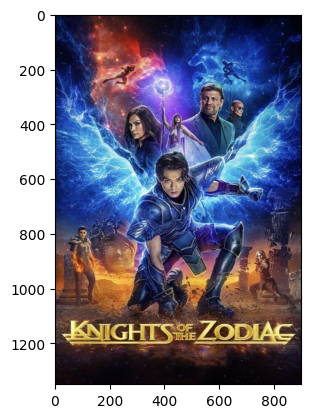

In [69]:
plt.imshow(load_image("1nbFEdIFprRNSWcCM0RUjQqZifF.jpg"))

In [73]:
upcoming_df[upcoming_df["poster_path"] == "1nbFEdIFprRNSWcCM0RUjQqZifF.jpg"]["genres"]

1    ['Fantasy', 'Action', 'Adventure']
Name: genres, dtype: object

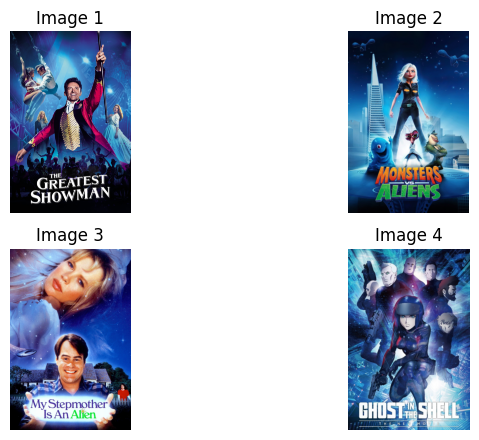

In [70]:
render_images(image_neighbors["1nbFEdIFprRNSWcCM0RUjQqZifF.jpg"])

In [85]:
get_predicted_genre(image_neighbors["1nbFEdIFprRNSWcCM0RUjQqZifF.jpg"])

[("['Drama']", 1),
 ("['Animation']", 1),
 ("['Comedy']", 1),
 ("['Science Fiction']", 1)]

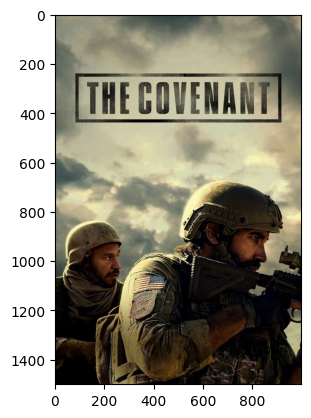

In [71]:
plt.imshow(load_image("aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg"))

In [87]:
upcoming_df[upcoming_df["poster_path"] == "aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg"]["genres"]

3    ['Action', 'Drama', 'War']
Name: genres, dtype: object

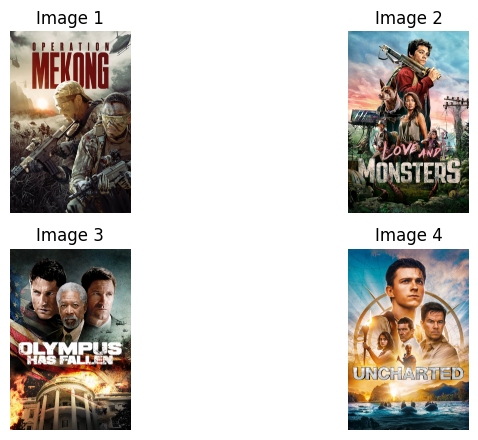

In [60]:
render_images(image_neighbors["aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg"])

In [86]:
get_predicted_genre(image_neighbors["aX0H63vho7rZ9Rm3I567Zf00Z1t.jpg"])

[("['Action']", 3), ("['Comedy']", 1)]

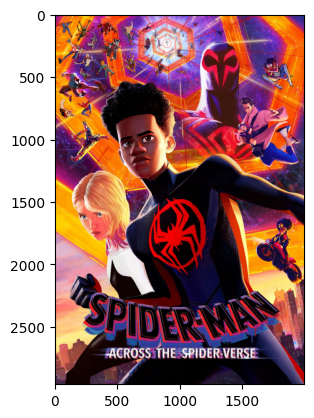

In [95]:
plt.imshow(load_image("zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg"))

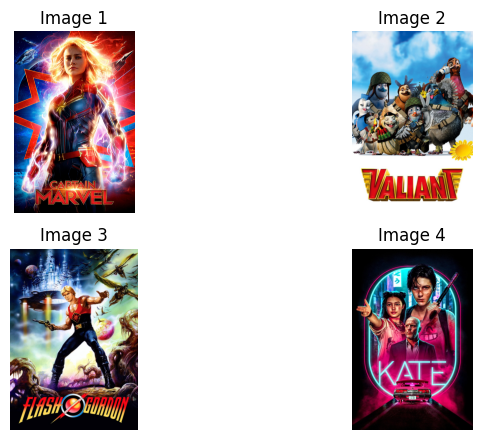

In [96]:
render_images(image_neighbors["zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg"])

In [97]:
upcoming_df[upcoming_df["poster_path"] == "zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg"]["genres"]

4    ['Animation', 'Action', 'Adventure', 'Science ...
Name: genres, dtype: object

In [98]:
get_predicted_genre(image_neighbors["zPoqAu4gxZRmcPzSLFJ9b0VciaL.jpg"])

[("['Action']", 2), ("['Family']", 1), ("['Science Fiction']", 1)]

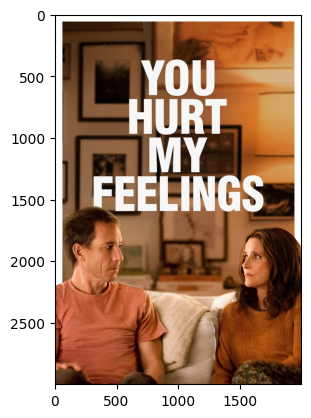

In [99]:
plt.imshow(load_image("do9UvkcDJeYbhYVoQPS00yOCYdc.jpg"))

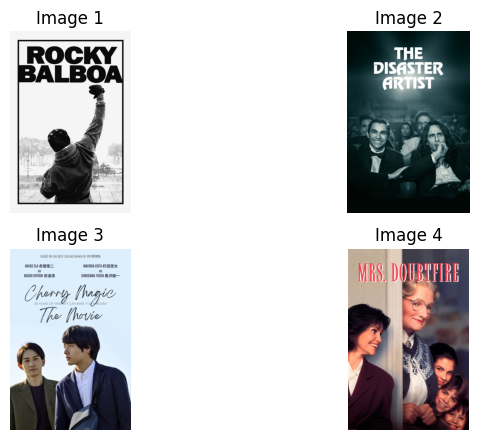

In [100]:
render_images(image_neighbors["do9UvkcDJeYbhYVoQPS00yOCYdc.jpg"])

In [102]:
upcoming_df[upcoming_df["poster_path"] == "do9UvkcDJeYbhYVoQPS00yOCYdc.jpg"]["genres"]

21    ['Comedy', 'Drama']
Name: genres, dtype: object

In [101]:
get_predicted_genre(image_neighbors["do9UvkcDJeYbhYVoQPS00yOCYdc.jpg"])

[("['Comedy']", 3), ("['Drama']", 1)]